In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/cell_images/cell_images"))

# Any results you write to the current directory are saved as output.

['Uninfected', 'Parasitized']


In [2]:
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torch import optim
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(64),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])
                                       
                                       ])

In [4]:
img_dir='../input/cell_images/cell_images/'
train_data = datasets.ImageFolder(img_dir,transform=train_transforms)

In [5]:
# number of subprocesses to use for data loading
num_workers = 0
# percentage of training set to use as validation
valid_size = 0.2

test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
valid_split = int(np.floor((valid_size) * num_train))
test_split = int(np.floor((valid_size+test_size) * num_train))
valid_idx, test_idx, train_idx = indices[:valid_split], indices[valid_split:test_split], indices[test_split:]

print(f'val_index: {len(valid_idx)},test_index: {len(test_idx)},train_index: {len(train_idx)}')

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=101,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=33, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=106,
    sampler=test_sampler, num_workers=num_workers)

val_index: 5511,test_index: 2756,train_index: 19291


In [6]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))
    
classes=['infected','uninfected']

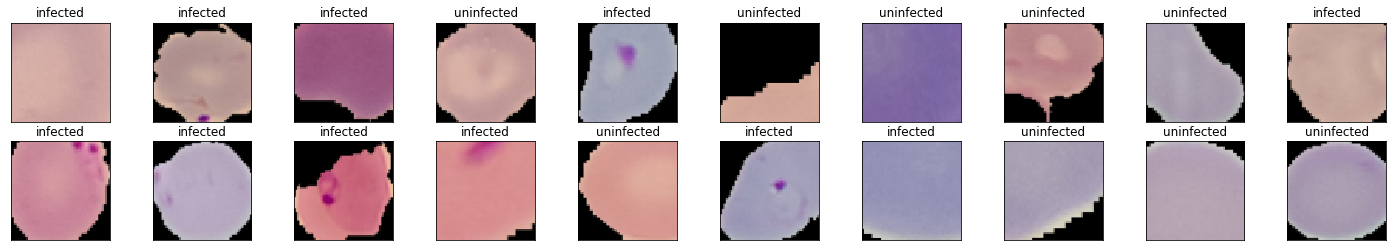

In [7]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1=nn.Conv2d(3,16,kernel_size=4)
        self.pool1=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.conv2=nn.Conv2d(16,32,kernel_size=(4,4))
        self.pool2=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.conv3=nn.Conv2d(32,64,kernel_size=(4,4))
        self.pool3=nn.MaxPool2d(kernel_size=(4,4),stride=2)
#         self.conv4=nn.Conv2d(64,128,kernel_size=(4,4))
#         self.pool4=nn.MaxPool2d(kernel_size=(3,3),stride=2)
        self.fc1=nn.Linear(4*4*64,500)
        self.fc2=nn.Linear(500,100)
        self.fc3=nn.Linear(100,2)
        self.dropout=nn.Dropout(0.25)
        
    def forward(self, x):
        
        x=self.pool1(F.relu(self.conv1(x)))
        x=self.dropout(x)
        x=self.pool2(F.relu(self.conv2(x)))
        x=self.dropout(x)
        x=self.pool3(F.relu(self.conv3(x)))
        x=self.dropout(x)
        x=x.reshape( -1,4*4*64)
        x=F.relu(self.fc1(x))
        x=self.dropout(x)
        x=F.relu(self.fc2(x))
        x=self.dropout(x)
        x=self.fc3(x)
        return x
        
        
        
    

In [9]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(4, 4), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
  (dropout): Dropout(p=0.25)
)


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
if torch.cuda.is_available():
    model = model.cuda()
#     criterion = criterion.cuda()

In [12]:
# number of epochs to train the model
n_epochs = 10

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.369125 	Validation Loss: 0.084777
Validation loss decreased (inf --> 0.084777).  Saving model ...
Epoch: 2 	Training Loss: 0.279204 	Validation Loss: 0.075609
Validation loss decreased (0.084777 --> 0.075609).  Saving model ...
Epoch: 3 	Training Loss: 0.270882 	Validation Loss: 0.072147
Validation loss decreased (0.075609 --> 0.072147).  Saving model ...
Epoch: 4 	Training Loss: 0.256944 	Validation Loss: 0.072498
Epoch: 5 	Training Loss: 0.253909 	Validation Loss: 0.068939
Validation loss decreased (0.072147 --> 0.068939).  Saving model ...
Epoch: 6 	Training Loss: 0.254148 	Validation Loss: 0.068310
Validation loss decreased (0.068939 --> 0.068310).  Saving model ...
Epoch: 7 	Training Loss: 0.246594 	Validation Loss: 0.067623
Validation loss decreased (0.068310 --> 0.067623).  Saving model ...
Epoch: 8 	Training Loss: 0.242157 	Validation Loss: 0.066902
Validation loss decreased (0.067623 --> 0.066902).  Saving model ...
Epoch: 9 	Training Loss: 0.247448 

In [13]:
model.load_state_dict(torch.load('model.pt'))

In [14]:

# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if torch.cuda.is_available():
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class

    
    for i in range(106):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.033052

Test Accuracy of infected: 77% (1092/1409)
Test Accuracy of uninfected: 93% (1264/1347)

Test Accuracy (Overall): 85% (2356/2756)


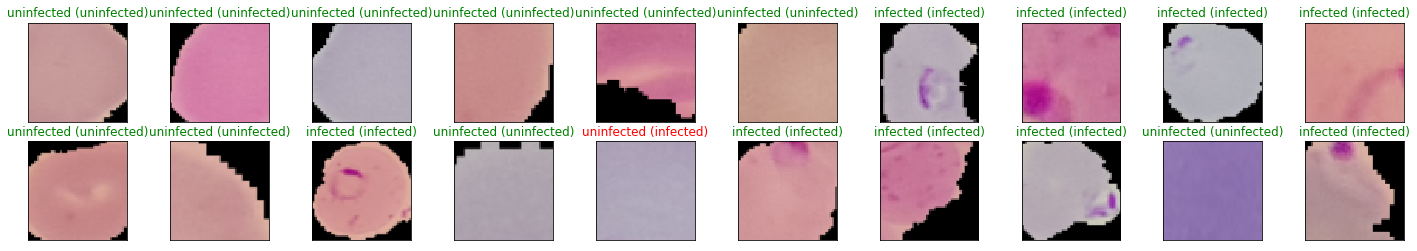

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if torch.cuda.is_available():
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))